In [ ]:
'''
Grid dataset information:
- 51 unique words in the data set
- 34 speakers with 1000 videos and annotations each
- All videos are 25fps and 3 seconds long
'''

'\nGrid dataset information:\n- 51 unique words in the data set\n- 34 speakers with 1000 videos and annotations each\n- All videos are 25fps and 3 seconds long\n'

# Imports

In [ ]:
'''
All imports for the project were done in this cell to prevent redundent loading of libraries when rerunning subsequent cells
'''
import torch
import torch.nn.functional as F
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
import os
import random
import time
import cv2
import math
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torch.optim as optim
from IPython.display import Video, HTML
from tqdm import tqdm
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from google.colab import drive
from google.colab.patches import cv2_imshow
!pip install remotezip tqdm opencv-python einops
import einops

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.2/43.2 kB 2.2 MB/s eta 0:00:00


# Global Variables

In [ ]:
NUM_VIDEOS = 1000 #number of videos that will be loaded and used in the CNN
NUM_FRAMES = 75 #Each video is ~75 frames
FPS = 25
TIME = 3
NUM_CLASSES = 53 #vocab size for the Grid Dataset
CLASS_PER_VIDEO = 8 #6 words per video with a silence placeholder on both sides of the sentence

'''
wanted to experiment with more complex randomization but never got around to it

#device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
#random.seed(time.time())
#RANDOM_SEED = random.randint(0, 2**32 - 1)

'''

RANDOM_SEED = 42 #Chose this seed as it was the one typically used in homework assignments

#Most if not all videos in Grid are 244x244
HEIGHT = 224
WIDTH = 224

color = True

# Dataset Import

In [ ]:
'''
Subset of the Grid Corpus was loaded into Colab for easier access to the data
The directory path may differ depending on location of the dataset
'''

drive.mount('/content/drive')
!unzip /content/drive/MyDrive/ec523/data.zip
root_dir = '/content/data'

Mounted at /content/drive
Archive:  /content/drive/MyDrive/ec523/data.zip
   creating: data/
  inflating: data/.DS_Store          
   creating: data/annotations/
   creating: data/videos/
  inflating: data/annotations/.DS_Store  
   creating: data/annotations/s1/
  inflating: data/videos/prwq3s.mpg  
  inflating: data/videos/pbib8p.mpg  
  inflating: data/videos/lrae3s.mpg  
  inflating: data/videos/pgid6p.mpg  
  inflating: data/videos/pbao8n.mpg  
  inflating: data/videos/prbx3s.mpg  
  inflating: data/videos/lbbk6p.mpg  
  inflating: data/videos/bgwu6n.mpg  
  inflating: data/videos/sbig6p.mpg  
  inflating: data/videos/pgby5s.mpg  
  inflating: data/videos/bras8p.mpg  
  inflating: data/videos/sgiczp.mpg  
  inflating: data/videos/lrwl7a.mpg  
  inflating: data/videos/bbbz8n.mpg  
  inflating: data/videos/bram3s.mpg  
  inflating: data/videos/pwwk7a.mpg  
  inflating: data/videos/bbws8n.mpg  
  inflating: data/videos/brbtzn.mpg  
  inflating: data/videos/bwwbzp.mpg  
  inflating: d

# Data View

Sample Video: pripzn.mpg
Corresponding Annotation: pripzn.align


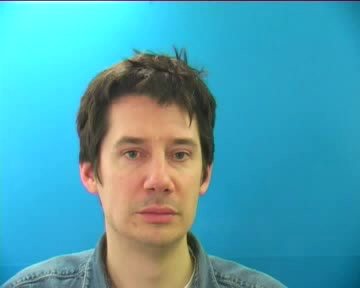


Annotation Content:
0 17000 sil
17000 24750 place
24750 28000 red
28000 31000 in
31000 34500 p
34500 43750 zero
43750 50750 now
50750 74500 sil



In [ ]:
'''
This cell is to provide a sample view of a video frame and its corresponding metadata (annotation)
It also serves to show the dimentions of the video frames and annotations
'''

def find_annotation_file(video_file):
    base_name = os.path.splitext(video_file)[0]
    annotation_file = base_name + '.align'
    return annotation_file

#videos_dir = os.path.join(root_dir, 'videos')
#annotations_dir = os.path.join(root_dir, 'annotations/s1') #This is the annotation files for Speaker 1 in the Grid Corpus

videos_dir = '/content/data/s1'
annotations_dir = '/content/data/alignments/s1'

video_files = os.listdir(videos_dir)

sample_video = video_files[0]
sample_annotation = find_annotation_file(sample_video)

print("Sample Video:", sample_video)
print("Corresponding Annotation:", sample_annotation)

video_path = os.path.join(videos_dir, sample_video)
cap = cv2.VideoCapture(video_path)
ret, frame = cap.read()
cap.release()

cv2_imshow(frame)

annotation_path = os.path.join(annotations_dir, sample_annotation)
with open(annotation_path, 'r') as annotation_file:
    annotation_content = annotation_file.read()
    print("\nAnnotation Content:")
    print(annotation_content)

def load_annotations(annotation_file):

    with open(annotation_file, 'r') as file:
        lines = file.readlines()
        token_annotations = []
        for line in lines:
          token_annotations.append(line.strip().split()[2])
        sentence_encode = [token[0] for token in tokenizer.texts_to_sequences(token_annotations)]


# Data Pre-Processing

In [ ]:
'''
This cell is for creating the token dictionary, tokenizing the annotation files, and creating the helper functions for loading the data
'''

tokens = ['a', 'again', 'at', 'b', 'bin', 'blue', 'by', 'c', 'd', 'e', 'eight',
          'f', 'five', 'four', 'g', 'green', 'h', 'i', 'in', 'j', 'k', 'l',
          'lay', 'm', 'n', 'nine', 'now', 'o', 'one', 'p', 'place', 'please',
          'q', 'r', 'red', 's', 'set', 'seven', 'sil', 'six', 'soon', 'sp', 't',
          'three', 'two', 'u', 'v', 'white', 'with', 'x', 'y', 'z', 'zero'] #all of the unique words used in the Grid Corpus (i.e the 53 word classes|vocab size)

tokenizer = Tokenizer()
tokenizer.fit_on_texts(tokens)

# Haar classifiers were found to be helpful
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
lips_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_smile.xml')

def process_video_frames(path):
  cap = cv2.VideoCapture(path)
  cropped_faces = []
  num_frames = 0

  while True:
    ret, raw = cap.read()
    if not ret or num_frames >= NUM_FRAMES:
      break
    frame = raw
    if not color:
      frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    for x in reversed(range(5,8)):
      face = face_cascade.detectMultiScale(frame,minNeighbors=x,minSize=(60,30), maxSize=(224,224))
      if len(face) > 0:
        break
    if len(face) == 0:
      face = [[50,150,200,100]]
    (x,y,w,h) = face[0]
    face = frame[y:y+h, x:x+w]
    for x in reversed(range(5,8)):
      lips = lips_cascade.detectMultiScale(frame,minNeighbors=x,minSize=(60,30), maxSize=(224,224))
      if len(lips) > 0:
        break
    if len(lips) == 0:
      lips = [[50,150,200,100]]
    (x,y,w,h) = lips[0]
    frame = frame[y:y+h, x:x+w]
    frame = cv2.normalize(frame, frame, 0, 100, cv2.NORM_MINMAX)
    frame = cv2.resize(frame, (WIDTH, HEIGHT))
    cropped_faces.append(frame)
    num_frames += 1
  cap.release()
  while len(cropped_faces) < NUM_FRAMES:
    cropped_faces.append(np.zeros_like(cropped_faces[0]))
  return cropped_faces


def process_data(video_path, annotation_path, word_count=8):
  video_count = len(video_path)
  annotation_count = len(annotation_path)
  video_dims = (NUM_FRAMES, HEIGHT, WIDTH)
  if color:
    video_dims = (NUM_FRAMES, HEIGHT, WIDTH, 3)
  annotation_dims = (CLASS_PER_VIDEO, )

  video_frames = []
  for i, path in enumerate(video_path):
    frames = process_video_frames(path)
    frames = np.array(frames[:NUM_FRAMES])
    video_frames.append(frames)
  annotations = []
  for i, path in enumerate(annotation_path):
    annotation_set = np.array(load_annotations(path))
    annotations.append(annotation_set)

  return np.array(video_frames), np.array(annotations)

# Data Loading

In [ ]:
'''
This cell is for loading in the dataset based on the global variable NUM_VIDEOS
'''

video_files = [os.path.join(videos_dir, file) for file in os.listdir(videos_dir) if file.endswith('.mpg')]
annotation_files = [os.path.join(annotations_dir, os.path.basename(file).replace('.mpg', '.align')) for file in video_files]
video_frames, annotations = process_data(video_files[:NUM_VIDEOS], annotation_files[:NUM_VIDEOS])

# Data Spliting

In [ ]:
'''
This cell is for splitting the data into training and validation sets
'''

X_train, X_val, y_train, y_val = train_test_split(video_frames, annotations, test_size=0.2, random_state=42)

print(X_train.shape)
print(X_val.shape)
print(y_train.shape)
print(y_val.shape)

(8, 75, 224, 224, 3)
(2, 75, 224, 224, 3)
(8,)
(2,)


# CNN Architecture

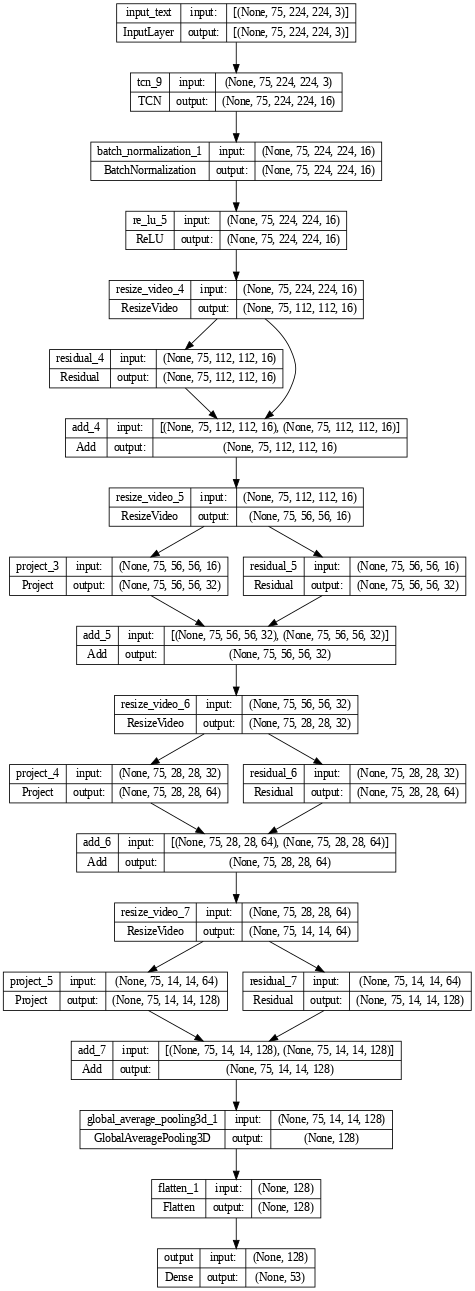

In [ ]:
'''
This cell is for defining the CNN architecture based on a simialr model found in keras tutorials dealing with TCN's
'''
class TCN(keras.layers.Layer):
  def __init__(self, filters, kernel_size, padding):
    super().__init__()
    self.seq = keras.Sequential([
        layers.Conv3D(filters=filters,
                      kernel_size=(1, kernel_size[1], kernel_size[2]),
                      padding=padding),
        layers.Conv3D(filters=filters,
                      kernel_size=(kernel_size[0], 1, 1),
                      padding=padding)
        ])

  def call(self, x):
    return self.seq(x)

class Residual(keras.layers.Layer):
  def __init__(self, filters, kernel_size):
    super().__init__()
    self.seq = keras.Sequential([
                TCN(filters=filters,
                    kernel_size=kernel_size,
                    padding='same'),
        layers.LayerNormalization(),
        layers.ReLU(),
                TCN(filters=filters,
                    kernel_size=kernel_size,
                    padding='same'),
        layers.LayerNormalization()
    ])

  def call(self, x):
    return self.seq(x)

class Project(keras.layers.Layer):
  def __init__(self, units):
    super().__init__()
    self.seq = keras.Sequential([
        layers.Dense(units),
        layers.LayerNormalization()
    ])

  def call(self, x):
    return self.seq(x)

def add_residual_block(input, filters, kernel_size):
  out = Residual(filters,kernel_size)(input)
  res = input
  if out.shape[-1] != input.shape[-1]:
    res = Project(out.shape[-1])(res)

  return layers.add([res, out])

class ResizeVideo(keras.layers.Layer):
  def __init__(self, height, width):
    super().__init__()
    self.height = height
    self.width = width
    self.resizing_layer = layers.Resizing(self.height, self.width)

  def call(self, video):
    old_shape = einops.parse_shape(video, 'b t h w c')
    images = einops.rearrange(video, 'b t h w c -> (b t) h w c')
    images = self.resizing_layer(images)
    videos = einops.rearrange(images, '(b t) h w c -> b t h w c',t = old_shape['t'])
    return videos

def Create_CNN_Model(vocab_size):
  input_shape = (None,75,224,224,3)
  input_text = layers.Input(shape=(input_shape[1:]), name='input_text')
  x = input_text
  x = TCN(filters=16, kernel_size=(7, 7, 7), padding='same')(x)
  x = layers.BatchNormalization()(x)
  x = layers.ReLU()(x)
  x = ResizeVideo(HEIGHT // 2, WIDTH // 2)(x)
  x = add_residual_block(x, 16, (5, 5, 5))
  x = ResizeVideo(HEIGHT // 4, WIDTH // 4)(x)
  x = add_residual_block(x, 32, (5, 5, 5))
  x = ResizeVideo(HEIGHT // 8, WIDTH // 8)(x)
  x = add_residual_block(x, 64, (5, 5, 5))
  x = ResizeVideo(HEIGHT // 16, WIDTH // 16)(x)
  x = add_residual_block(x, 128, (5, 5, 5))
  x = layers.GlobalAveragePooling3D()(x)
  x = layers.Flatten()(x)
  output = layers.Dense(vocab_size, name='output')(x)
  model = keras.Model(inputs=input_text,outputs=output)
  return model

CNN_Model = Create_CNN_Model(NUM_CLASSES)
keras.utils.plot_model(CNN_Model, expand_nested=True, dpi=60, show_shapes=True)

# Training

In [ ]:
'''
This cell is for training the CNN
'''

CNN_Model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
history = CNN_Model.fit(X_train,y_train, epochs=1, batch_size=5, validation_data=(X_val,y_val))
loss, accuracy = CNN_Model.evaluate(X_val, y_val)
print("Validation Loss:", loss)
print("Validation Accuracy:", accuracy)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()